In [1]:
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

# Read in data for Japan and rename columns
Japan_df = pd.read_csv('Japan stats(csv).csv')[2:]
Japan_df = Japan_df.rename(columns={'International Financial Statistics (IFS)': 'Date', 'Unnamed: 1': 'Japan Industrial production (Index)', 'Unnamed: 2': 'Japan Exchange rates relative to the US dollar (Period Average)', 'Unnamed: 3': 'Japan Consumer prices (All items)', 'Unnamed: 4': 'Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'})

# Read in data for USA and rename columns
USA_df = pd.read_csv('USA stats(csv).csv')[2:]
USA_df = USA_df.rename(columns={'Unnamed: 1': 'USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)', 'Unnamed: 2': 'USA Consumer prices (All items)'})
USA_df = USA_df[['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)', 'USA Consumer prices (All items)']]

# Merge data for both countries
Country_data = pd.concat([Japan_df, USA_df], axis=1)
Country_data = Country_data[['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)', 'USA Consumer prices (All items)', 'Japan Industrial production (Index)', 'Japan Exchange rates relative to the US dollar (Period Average)', 'Japan Consumer prices (All items)', 'Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)']].replace(',', '', regex=True).astype(float)
Country_data = pd.concat([Japan_df['Date'], Country_data], axis=1)

#convert into time series and removed any annual values
Country_data = Country_data[Country_data['Date'].str.len() > 4]
Country_data['Date'] = pd.to_datetime(Country_data['Date'], format='%b %Y')


#creating variables for Japan and USA
Japan_variables = pd.DataFrame()

Japan_variables['log_exchange_rate'] = np.log(Country_data['Japan Exchange rates relative to the US dollar (Period Average)'])
Japan_variables['log_exchange_rate_diff'] = Japan_variables['log_exchange_rate'] - Japan_variables['log_exchange_rate'].shift(1)
Japan_variables['inflation_rate'] = (((Country_data['Japan Consumer prices (All items)'] - Country_data['Japan Consumer prices (All items)'].shift(1))/Country_data['Japan Consumer prices (All items)'].shift(1)))*100
Japan_variables['log_industrial'] = np.log(Country_data['Japan Industrial production (Index)'])
Japan_variables['monthly_industrial_change'] = Country_data['Japan Industrial production (Index)'] - Country_data['Japan Industrial production (Index)'].shift(1)
Japan_variables['yearly_industrial_change'] = Country_data['Japan Industrial production (Index)'] - Country_data['Japan Industrial production (Index)'].shift(12)
Japan_variables['international_reserves_index'] = (Country_data['Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'] / Country_data['Japan International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'][2])*100
Japan_variables['nominal_exchange_rate_growth'] = (Country_data['Japan Exchange rates relative to the US dollar (Period Average)']/Country_data['Japan Exchange rates relative to the US dollar (Period Average)'].shift(1)-1)*100

USA_variables = pd.DataFrame()

USA_variables['inflation_rate'] = (((Country_data['USA Consumer prices (All items)'] - Country_data['USA Consumer prices (All items)'].shift(1))/Country_data['USA Consumer prices (All items)'].shift(1)))*100
USA_variables['international_reserves_index'] = (Country_data['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'] / Country_data['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'][2])*100


In [2]:
def outlier_check(df, threshold = 3):
    outliers = pd.DataFrame()
    for col in df.columns:
        z = np.abs((df[col] - df[col].mean()) / df[col].std())
        outliers = pd.concat([outliers, df[z > threshold]], axis=0)
    return outliers

Japan_outliers = outlier_check(Japan_variables)
USA_outliers = outlier_check(USA_variables)



#any day that USA and Japan have what we would consider an outlier, it is unlikely to be a random change within the data, may be reflective of a more global trend.
common_index = Japan_outliers.index.intersection(USA_outliers.index)
Japan_true_outliers = Japan_outliers.drop(common_index)

In [3]:
#setting true outliers as missing
for col in Japan_variables.columns:
    for idx, row in Japan_variables.iterrows():
        if idx in Japan_true_outliers.index:
            z = np.abs((Japan_variables[col] - Japan_variables[col].mean()) / Japan_variables[col].std())
            Japan_variables.loc[z > 3, col] = np.nan
            
Japan_variables.iloc[0] = Japan_variables.iloc[0].fillna(value=0)
Japan_variables = Japan_variables.interpolate(method='linear')
Japan_variables = pd.concat([Country_data['Date'], Japan_variables], axis= 1)

cpi_ratio = Country_data['USA Consumer prices (All items)'] / Country_data['Japan Consumer prices (All items)']
Japan_variables['log_real_exchange_rate_diff'] = Japan_variables['log_exchange_rate_diff'] + np.log(cpi_ratio)
Japan_variables['real_exchange_rate_growth'] = np.exp(Japan_variables['log_real_exchange_rate_diff']) * 100 

Text(0, 0.5, 'Japanese Yen relative to the US dollar (Period Average)')

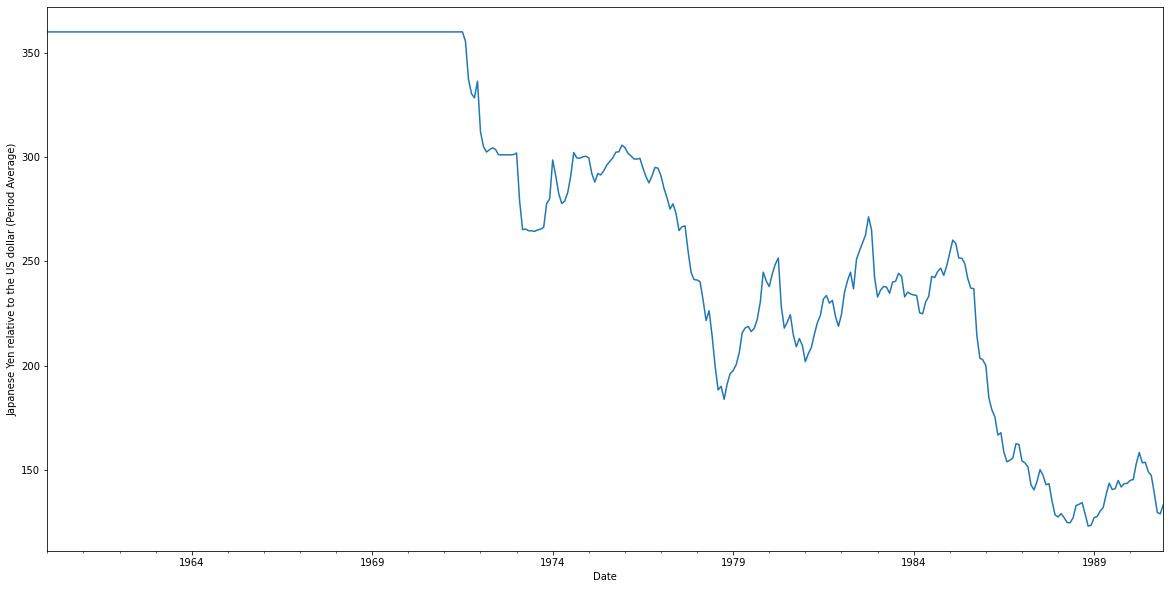

In [4]:
Country_data.set_index('Date', inplace=True)
Country_data['Japan Exchange rates relative to the US dollar (Period Average)'].plot(figsize=(20, 10))
plt.ylabel('Japanese Yen relative to the US dollar (Period Average)')

0.2729179104790983


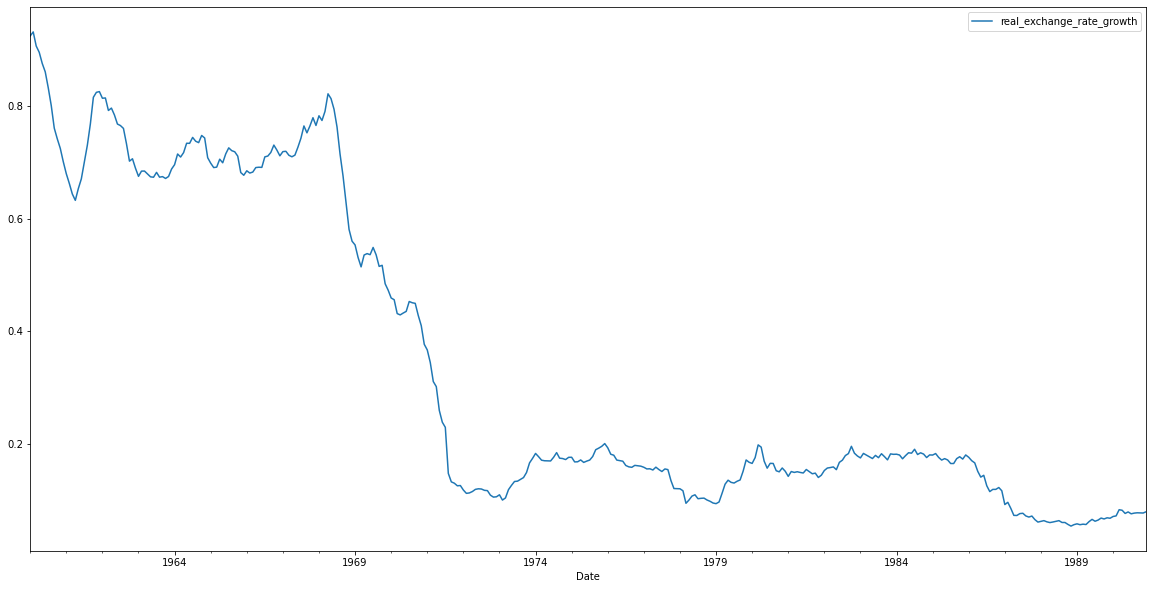

In [5]:
cols_to_plot = ['real_exchange_rate_growth']
Japan_variables.set_index('Date', inplace=True)
Japan_variables[cols_to_plot].plot(figsize=(20, 10))

print(Japan_variables['real_exchange_rate_growth'].std())


<AxesSubplot:xlabel='Date'>

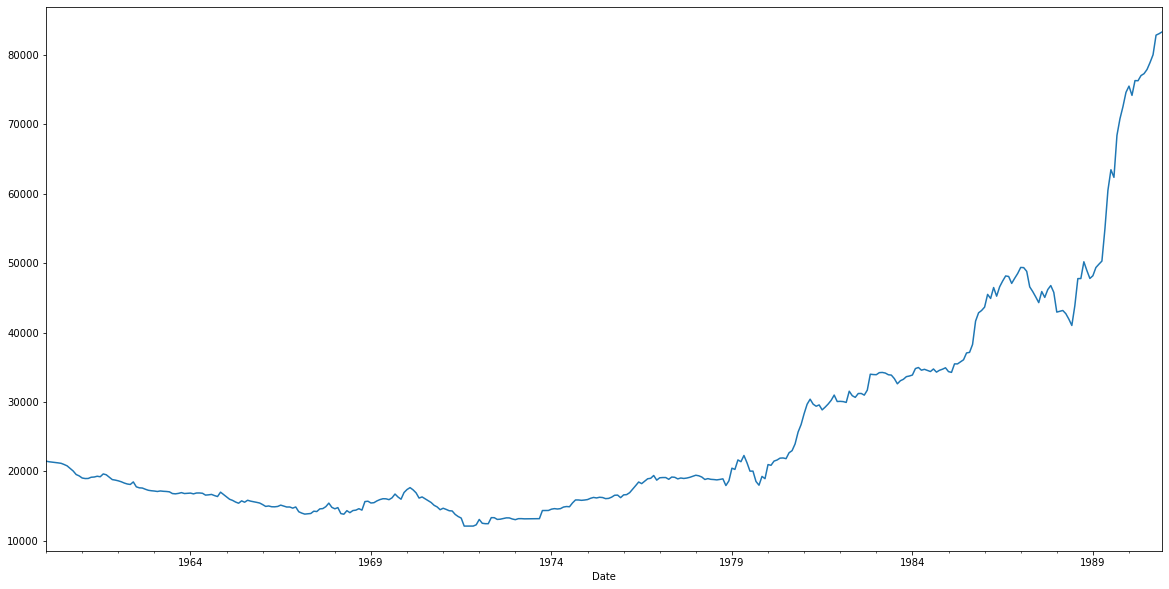

In [6]:

Country_data['USA International Reserves and Liquidity (Reserves, Official Reserve Assets, US Dollar)'].plot(figsize=(20, 10))

Date
1968-05-01    360.00
1968-06-01    360.00
1968-07-01    360.00
1968-08-01    360.00
1968-09-01    360.00
1968-10-01    360.00
1968-11-01    360.00
1968-12-01    360.00
1969-01-01    360.00
1969-02-01    360.00
1969-03-01    360.00
1969-04-01    360.00
1969-05-01    360.00
1969-06-01    360.00
1969-07-01    360.00
1969-08-01    360.00
1969-09-01    360.00
1969-10-01    360.00
1969-11-01    360.00
1969-12-01    360.00
1970-01-01    360.00
1970-02-01    360.00
1970-03-01    360.00
1970-04-01    360.00
1970-05-01    360.00
1970-06-01    360.00
1970-07-01    360.00
1970-08-01    360.00
1970-09-01    360.00
1970-10-01    360.00
1970-11-01    360.00
1970-12-01    360.00
1971-01-01    360.00
1971-02-01    360.00
1971-03-01    360.00
1971-04-01    360.00
1971-05-01    360.00
1971-06-01    360.00
1971-07-01    360.00
1971-08-01    355.52
1971-09-01    337.40
1971-10-01    330.42
1971-11-01    328.40
1971-12-01    336.39
1972-01-01    312.23
1972-02-01    304.98
1972-03-01    302.44
1972-04-

In [19]:
#calculating standard deviations:

def std_before_and_after(df, col):
    std_before = df[col][:'1970-10-01'].std()
    std_after = df[col]['1972-06-01':].std()
    print('before Japan left Bretton Wood, excluding the 10 months before is ' + str(std_before) + ', after Japan left Bretton Woods, excluding the 10 months after is ' + str(std_after))
    
    
#nominal exchange rate growth before and after
std_before_and_after(Japan_variables, 'nominal_exchange_rate_growth')

#real rate growth before and after
std_before_and_after(Japan_variables, 'real_exchange_rate_growth')

#inflation rate before and after
std_before_and_after(Japan_variables, 'inflation_rate')

Japan_variables['diff_in_inflation_rate_Japan_v_USA'] = Japan_
#difference in inflation rates before and after
std_before_and_after(Japan_variables, 'real_exchange_rate_growth')

#annual industrial for japan before and after



before Japan left Bretton Wood, excluding the 10 months before is 0.0, after Japan left Bretton Woods, excluding the 10 months after is 2.2351735459629
before Japan left Bretton Wood, excluding the 10 months before is 0.1108587766349391, after Japan left Bretton Woods, excluding the 10 months after is 0.04298648825192145
before Japan left Bretton Wood, excluding the 10 months before is 2.6014339773069737, after Japan left Bretton Woods, excluding the 10 months after is 2.463024020849039
